In [1]:
from keras.callbacks import Callback,EarlyStopping, ModelCheckpoint
from keras.backend import clear_session
from keras.models import Model, load_model
from keras.layers import Dense, Input, Flatten
from keras.applications import ResNet50, MobileNet, Xception, DenseNet121
from keras import regularizers
import os
import cv2
import numpy as np
import pandas as pd

from collections import Counter

#from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:

def build_model(mode, model_name = None, model_path = None):

    clear_session()

    if mode == 'train':#모델을 만들고, fully connected layer 추가 및 compile 까지
        img = Input(shape = (224, 224, 3))#네트워크에 주입할 입력텐서의 크기. 이 값을 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리 가능

        if model_name == 'DenseNet121':

            model = DenseNet121(include_top=False,  #최상위 Fully_connected_layer 포함여부. 마지막 dense layer만 학습. pre-trained
                                weights='imagenet', #모델을 초기화할 가중치 체크포인트
                                input_tensor=img, 
                                input_shape=None, 
                                pooling='avg')

        elif model_name == 'MobileNet':

            model = MobileNet(include_top=False, 
                              weights='imagenet', 
                              input_tensor=img, 
                              input_shape=None, 
                              pooling='avg')

        elif model_name == 'Xception':

            model = Xception(include_top=False, 
                             weights='imagenet', 
                             input_tensor=img, 
                             input_shape=None, 
                             pooling='avg')

        elif model_name == 'ResNet50':

            model = ResNet50(include_top=False, 
                             weights='imagenet', 
                             input_tensor=img, 
                             input_shape=None, 
                             pooling='avg')

        final_layer = model.layers[-1].output

        dense_layer_1 = Dense(128, activation = 'relu',kernel_regularizer=regularizers.l2(0.001))(final_layer)
        output_layer = Dense(74, activation = 'sigmoid',kernel_regularizer=regularizers.l2(0.001))(dense_layer_1)

        model = Model(input = img, output = output_layer)
        model.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'])
        #binary_cross entropy: 0,1
        #categorital_cross entropy: 더 다양한 분류. 즉, 같은 것인데 binary~가 더 specific 한 case

    elif mode == 'inference':
        model = load_model(model_path)

    return model


In [3]:
def one_hot_encode(i,num_of_class):
    result = np.zeros((num_of_class,))
    result[i]=1
    return result

In [4]:
#one_hot_encode exercise
"""
a = one_hot_encode(2,5)
b = one_hot_encode(3,5)
print(type(a))
x =[]
x.append(a)
x.append(b)#list type
print(x)
x = np.asarray(x).astype('float32') #list를 asarray 해주어야 함
print(x)
"""

"\na = one_hot_encode(2,5)\nb = one_hot_encode(3,5)\nprint(type(a))\nx =[]\nx.append(a)\nx.append(b)#list type\nprint(x)\nx = np.asarray(x).astype('float32') #list를 asarray 해주어야 함\nprint(x)\n"

In [5]:

def load_data(path): #path: image가 저장되어 있는 경로
                     #D:\\food-classification\\image\\
                     #train,test,val data 분리 및 resize
    
    #list 형태로 선언(후에 np.array로 타입변환)
    trainX, testX, valX = [], [], []
    trainY, testY, valY = [], [], []
    
    num_of_food = len(os.listdir(path))#image폴더의 개수. 즉, 분류class의 개수
    for i in range(num_of_food):
        
        """
        item = df.loc[i][0] #type(df):pandas.core.frame.Dataframe ex) apple_pie
        current_label = np.array((df.loc[i])[1:]) #numpy형식으로 바꿔줌 ex) [0,0,1,0,0,0,1,0,1,0]
        """
        item = os.listdir(path)[i]
        print("item: ",item)
        current_label = one_hot_encode(i,num_of_food)
        
        image_path = os.path.join(path, item) #image폴더
        print("image_path: ",image_path)
        list_of_imgs = [os.path.join(image_path, file) for file in os.listdir(image_path)]
        train_set = list_of_imgs[:30] #경로들이 저장되어있는 리스트
        val_set = list_of_imgs[30:40]
        test_set = list_of_imgs[40:]  #30,10 개 만큼 train,valid 나머지 test
        
        for file in train_set:
            img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (224, 224))
            #cv2.imread(file_path,flag) #flag=1 이면 color로 읽음
            #cv2.cvtColor 컬러 변환 함수 BGR2RGB 원래 BlueGreenRed ->RedGreenBlue로 바꿔줌
            #cv2.resize( , (224,224)) 사진크기 트레이닝 모델에 맞게 구성
            trainX.append(img)
            trainY.append(current_label)
        
        for file in val_set:
            img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (224, 224))
            valX.append(img)
            valY.append(current_label)
        
        for file in test_set:
            img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (224, 224))
            testX.append(img)
            testY.append(current_label)
            
    return (np.asarray(trainX).astype('float32'), np.asarray(trainY).astype('float32'), np.asarray(testX).astype('float32'), 
            np.asarray(testY).astype('float32'), np.asarray(valX).astype('float32'), np.asarray(valY).astype('float32'))#np.array(x)로 타입변환 및 float32로

In [6]:
"""
def train(model_name):
    
    #data set 받아오기 및 분류
    trainX, trainY, testX, testY, valX, valY = load_data("D:\\food-classification\\image\\")
    print("data loaded")


    #rgb에 대한 각각의 mean,std를 구한다
    MEAN = np.mean(trainX, axis = (0,1,2))
    STD = np.std(trainX, axis = (0,1,2))

    for i in range(3):#rgb 값에 대해서
        #shape (num_of_samples, height,width,channel)
        trainX[:, :, :, i] = (trainX[:, :, :, i] - MEAN[i]) / STD[i]
        testX[:, :, :, i] = (testX[:, :, :, i] - MEAN[i]) / STD[i]
        valX[:, :, :, i] = (valX[:, :, :, i] - MEAN[i]) / STD[i]
        #test와 valid set또한 trainset 의 mean 과 std를 사용함 주의!!

    model = build_model('train', model_name) #모델생성 및 compile까지

    model_result = model_name+".h5"
    callbacks_list=[
    EarlyStopping(monitor='val_acc',patience=1),
    #1에포크보다 길게 val성능이 향상되지 않으면 훈련 중지
    ModelCheckpoint(filepath=model_result,monitor='val_loss',save_best_only=True)]
    #성능이 좋아지지 않으면 가중치 업데이트x
 
    ## Training model.
    history = model.fit(trainX, trainY, batch_size = 32, epochs = 25, validation_data = (valX, valY), 
              callbacks = callbacks_list)
    
    return history

    """
   

'\ndef train(model_name):\n    \n    #data set 받아오기 및 분류\n    trainX, trainY, testX, testY, valX, valY = load_data("D:\\food-classification\\image\\")\n    print("data loaded")\n\n\n    #rgb에 대한 각각의 mean,std를 구한다\n    MEAN = np.mean(trainX, axis = (0,1,2))\n    STD = np.std(trainX, axis = (0,1,2))\n\n    for i in range(3):#rgb 값에 대해서\n        #shape (num_of_samples, height,width,channel)\n        trainX[:, :, :, i] = (trainX[:, :, :, i] - MEAN[i]) / STD[i]\n        testX[:, :, :, i] = (testX[:, :, :, i] - MEAN[i]) / STD[i]\n        valX[:, :, :, i] = (valX[:, :, :, i] - MEAN[i]) / STD[i]\n        #test와 valid set또한 trainset 의 mean 과 std를 사용함 주의!!\n\n    model = build_model(\'train\', model_name) #모델생성 및 compile까지\n\n    model_result = model_name+".h5"\n    callbacks_list=[\n    EarlyStopping(monitor=\'val_acc\',patience=1),\n    #1에포크보다 길게 val성능이 향상되지 않으면 훈련 중지\n    ModelCheckpoint(filepath=model_result,monitor=\'val_loss\',save_best_only=True)]\n    #성능이 좋아지지 않으면 가중치 업데이트x\n \n    ## 

In [7]:

def train(model_name,trainX,trainY,valX,valY):

    model = build_model('train', model_name) #모델생성 및 compile까지

    model_result = model_name+"01"+".h5"
    callbacks_list=[
    EarlyStopping(monitor='val_acc',patience=3),
    #1에포크보다 길게 val성능이 향상되지 않으면 훈련 중지
    ModelCheckpoint(filepath=model_result,monitor='val_loss',save_best_only=True)]
    #성능이 좋아지지 않으면 가중치 업데이트x
 
    ## Training model.
    history = model.fit(trainX, trainY, batch_size = 32, epochs = 25, validation_data = (valX, valY), 
              callbacks = callbacks_list)
    
    return model, history
 

In [8]:
import matplotlib.pyplot as plt

In [9]:
def show_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)
    
    # ‘bo’는 파란색 점을 의미합니다
    plt.plot(epochs, acc, 'bo', label='Training acc')
    # ‘b’는 파란색 실선을 의미합니다
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Acc')
    plt.legend()


    plt.show()

In [10]:
def show_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [11]:
trainX, trainY, testX, testY, valX, valY = load_data("D:\\food-classification\\image\\")
print("data loaded")

#rgb에 대한 각각의 mean,std를 구한다
MEAN = np.mean(trainX, axis = (0,1,2))
STD = np.std(trainX, axis = (0,1,2))

for i in range(3):#rgb 값에 대해서
    #shape (num_of_samples, height,width,channel)
    trainX[:, :, :, i] = (trainX[:, :, :, i] - MEAN[i]) / STD[i]
    testX[:, :, :, i] = (testX[:, :, :, i] - MEAN[i]) / STD[i]
    valX[:, :, :, i] = (valX[:, :, :, i] - MEAN[i]) / STD[i]
#test와 valid set또한 trainset 의 mean 과 std를 사용함 주의!!
print("normalization done")

model, history = train("MobileNet",trainX,trainY,valX,valY)

item:  aguchim
image_path:  D:\food-classification\image\aguchim
item:  banmi
image_path:  D:\food-classification\image\banmi
item:  banSeo
image_path:  D:\food-classification\image\banSeo
item:  bibimbab
image_path:  D:\food-classification\image\bibimbab
item:  boSam
image_path:  D:\food-classification\image\boSam
item:  britto
image_path:  D:\food-classification\image\britto
item:  bunzza
image_path:  D:\food-classification\image\bunzza
item:  chicken
image_path:  D:\food-classification\image\chicken
item:  ChickenLeg
image_path:  D:\food-classification\image\ChickenLeg
item:  chobab
image_path:  D:\food-classification\image\chobab
item:  coldnoodles
image_path:  D:\food-classification\image\coldnoodles
item:  colnamulGukbab
image_path:  D:\food-classification\image\colnamulGukbab
item:  DaeZiGalBi
image_path:  D:\food-classification\image\DaeZiGalBi
item:  DaeZiKookBab
image_path:  D:\food-classification\image\DaeZiKookBab
item:  DanZZangZZigae
image_path:  D:\food-classification\im

W0806 14:45:25.880859  8312 deprecation_wrapper.py:119] From C:\Users\yurim\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0806 14:45:25.881852  8312 deprecation_wrapper.py:119] From C:\Users\yurim\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0806 14:45:25.895868  8312 deprecation_wrapper.py:119] From C:\Users\yurim\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 14:45:25.896845  8312 deprecation_wrapper.py:119] From C:\Users\yurim\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Pl

normalization done


C:\graduateproject\anaconda\lib\site-packages\ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
W0806 14:45:28.427748  8312 deprecation_wrapper.py:119] From C:\Users\yurim\AppData\Roaming\Python\Python37\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0806 14:45:28.448836  8312 deprecation.py:323] From C:\Users\yurim\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2220 samples, validate on 740 samples
Epoch 1/25
2220/2220 [==============================] - 968s 436ms/step - loss: 0.3541 - acc: 0.9696 - val_loss: 0.2430 - val_acc: 0.9866
Epoch 2/25
2220/2220 [==============================] - 972s 438ms/step - loss: 0.1677 - acc: 0.9883 - val_loss: 0.1522 - val_acc: 0.9866
Epoch 3/25
2220/2220 [==============================] - 970s 437ms/step - loss: 0.1035 - acc: 0.9909 - val_loss: 0.1119 - val_acc: 0.9873
Epoch 4/25
2220/2220 [==============================] - 967s 436ms/step - loss: 0.0722 - acc: 0.9940 - val_loss: 0.0939 - val_acc: 0.9873
Epoch 5/25
2220/2220 [==============================] - 974s 439ms/step - loss: 0.0556 - acc: 0.9966 - val_loss: 0.0832 - val_acc: 0.9876
Epoch 6/25
2220/2220 [==============================] - 967s 436ms/step - loss: 0.0460 - acc: 0.9985 - val_loss: 0.0746 - val_acc: 0.9879
Epoch 7/25
2220/2220 [==============================] - 989s 446ms/step - loss: 0.0404 - acc: 0.9991 - val_loss: 0.0742 - val

In [12]:
results = model.evaluate(testX,testY)
print(results)

1347/1347 [==============================] - 153s 114ms/step
[0.06580956857416394, 0.9880615312166363]


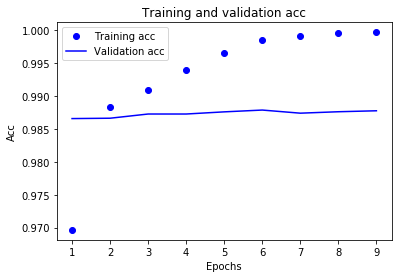

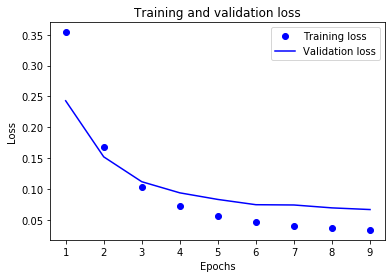

In [14]:
show_acc(history)
show_loss(history)

In [ ]:
#model = build_model('train', 'ResNet50')
#model.summary()